In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn import metrics as mtr

import operator
import pickle
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

np.random.seed(20160614)
tf.set_random_seed(20160614)

In [25]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 200) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.3f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [26]:
df = pd.read_csv('../01.data/02.train/data_2013_2017.csv', index_col=0)

In [27]:
df.head()

,target,wd_Monday,wd_Thursday,wd_Wednesday,wd_Thursday.1,wd_Friday,up_flg,down_flg,up_cnt_rolling5_0.0,up_cnt_rolling5_1.0,up_cnt_rolling5_2.0,up_cnt_rolling5_3.0,up_cnt_rolling5_4.0,up_cnt_rolling5_5.0,up_must_length,down_must_length,box_length,RCI9_p,RCI9_m,RCI9_slope_p,RCI9_slope_m,RSI,RSI_slope,cross_25_50_-1,cross_25_50_1,cross_25_75_-1,cross_25_75_1,cross_50_75_-1,cross_50_75_1,MA25_slope_p,MA25_slope_m,MA50_slope_p,MA50_slope_m,MA75_slope_p,MA75_slope_m,MA25_dev_p,MA25_dev_m,BLGR_sigma_p_dev_p,BLGR_sigma_p_dev_m,BLGR_2sigma_p_dev_p,BLGR_2sigma_p_dev_m,BLGR_sigma_m_dev_p,BLGR_sigma_m_dev_m,BLGR_2sigma_m_dev_p,BLGR_2sigma_m_dev_m
trading_day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-04-17,1,0,0,1,0,0,0,1,0,0,1,0,0,0,84,146,71,30.000,0.000,21.667,0.000,62.037,-2.113,0,0,0,0,0,0,38.240,0.000,37.280,0.000,32.813,0.000,0.041,0.000,0.005,0.000,0.000,-0.028,0.079,0.000,0.121,0.000
2013-04-18,1,0,1,0,1,0,1,0,0,0,1,0,0,0,98,83,6,53.333,0.000,23.333,0.000,62.190,0.153,0,0,0,0,0,0,33.200,0.000,38.640,0.000,33.733,0.000,0.039,0.000,0.003,0.000,0.000,-0.031,0.078,0.000,0.120,0.000
2013-04-19,0,0,0,0,0,1,1,0,0,0,0,1,0,0,29,99,274,43.333,0.000,0.000,-10.000,66.668,4.478,0,0,0,0,0,0,43.280,0.000,48.140,0.000,37.493,0.000,0.057,0.000,0.019,0.000,0.000,-0.017,0.098,0.000,0.143,0.000
2013-04-22,0,1,0,0,0,0,0,1,0,0,0,1,0,0,30,94,33,36.667,0.000,0.000,-6.667,66.865,0.197,0,0,0,0,0,0,46.800,0.000,43.960,0.000,39.467,0.000,0.054,0.000,0.015,0.000,0.000,-0.021,0.096,0.000,0.142,0.000
2013-04-23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,28,126,149,3.333,0.000,0.000,-33.333,69.285,2.420,0,0,0,0,0,0,51.360,0.000,47.180,0.000,44.200,0.000,0.062,0.000,0.022,0.000,0.000,-0.016,0.106,0.000,0.154,0.000


In [28]:
# 学習データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[:, 1:df.shape[1]], 
                                                    df['target'], 
                                                    test_size=0.3, 
                                                    random_state=100)

In [29]:
# 学習データと検証データの正解含有率とレコード件数
print ('train data || Correct Data Rate : %f, Length of data: %i' % (y_train.sum()/len(y_train), len(y_train)))
print ('valid data || Correct Data Rate : %f, Length of data: %i' % (y_valid.sum()/len(y_valid), len(y_valid)))

train data || Correct Data Rate : 0.175234, Length of data: 856
valid data || Correct Data Rate : 0.185286, Length of data: 367


In [30]:
# 変数マップを作成する
def create_feature_map(features):
    outfile = open('10.fmap/xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [31]:
# 説明変数
explanatory_colums = ['target',	'wd_Monday',	'wd_Thursday',	'wd_Wednesday',	'wd_Thursday',	'wd_Friday',	'up_flg',	
              'down_flg',	'up_cnt_rolling5_0.0',	'up_cnt_rolling5_1.0',	'up_cnt_rolling5_2.0',	'up_cnt_rolling5_3.0',	
              'up_cnt_rolling5_4.0',	'up_cnt_rolling5_5.0',	'up_must_length',	'down_must_length',	'box_length',	'RCI9_p',
              'RCI9_m',	'RCI9_slope_p',	'RCI9_slope_m',	'RSI',	'RSI_slope',	'cross_25_50_-1',	'cross_25_50_1',	'cross_25_75_-1',
              'cross_25_75_1',	'cross_50_75_-1',	'cross_50_75_1',	'MA25_slope_p',	'MA25_slope_m',	'MA50_slope_p',	'MA50_slope_m',
              'MA75_slope_p',	'MA75_slope_m',	'MA25_dev_p',	'MA25_dev_m',	'BLGR_sigma_p_dev_p',	'BLGR_sigma_p_dev_m',
              'BLGR_2sigma_p_dev_p',	'BLGR_2sigma_p_dev_m',	'BLGR_sigma_m_dev_p',	'BLGR_sigma_m_dev_m',	'BLGR_2sigma_m_dev_p',
              'BLGR_2sigma_m_dev_m']

In [32]:
# 説明変数のfeature mapを作成
create_feature_map(explanatory_colums)

### モデル定義

In [33]:
# parameters setting
# n_estimators and early_stopping_rounds should be increased
model = xgb.XGBClassifier(missing=np.nan, 
                        max_depth=7, # Maximum delta step we allow each tree’s weight estimation to be.
                        n_estimators=300, # Number of boosted trees to fit
                        learning_rate=0.05, 
                        subsample=1, 
                        colsample_bytree=0.9, 
                        seed=2100,
                        objective= 'binary:logistic')

In [34]:
# fitting
model.fit(X_train, 
          y_train,  
          early_stopping_rounds=35,  
          eval_metric="logloss", 
          eval_set=[(X_valid, y_valid)] # dataset to use validation for early-stopping 
         )

[0]	validation_0-logloss:0.672533
Will train until validation_0-logloss hasn't improved in 35 rounds.
[1]	validation_0-logloss:0.655815
[2]	validation_0-logloss:0.639621
[3]	validation_0-logloss:0.624144
[4]	validation_0-logloss:0.6091
[5]	validation_0-logloss:0.598187
[6]	validation_0-logloss:0.586243
[7]	validation_0-logloss:0.576043
[8]	validation_0-logloss:0.566968
[9]	validation_0-logloss:0.559288
[10]	validation_0-logloss:0.552758
[11]	validation_0-logloss:0.544274
[12]	validation_0-logloss:0.537088
[13]	validation_0-logloss:0.531669
[14]	validation_0-logloss:0.525779
[15]	validation_0-logloss:0.521022
[16]	validation_0-logloss:0.515306
[17]	validation_0-logloss:0.5104
[18]	validation_0-logloss:0.507182
[19]	validation_0-logloss:0.504924
[20]	validation_0-logloss:0.502692
[21]	validation_0-logloss:0.499349
[22]	validation_0-logloss:0.496507
[23]	validation_0-logloss:0.49344
[24]	validation_0-logloss:0.490751
[25]	validation_0-logloss:0.488937
[26]	validation_0-logloss:0.487007
[2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2100,
       silent=True, subsample=1)

In [35]:
# pred_probaのアウトプットには、1に分類される確率が配列の2つ目に格納される
pred = model.predict_proba(X_valid)[:, 1]

In [36]:
from  sklearn.metrics import log_loss
logloss_valid = log_loss(y_valid, pred)
logloss_valid

0.47286641364536508

In [37]:
# ROC曲線用の変数作成
fpr, tpr, thresholds = mtr.roc_curve(y_valid.values, pred)
roc_auc = auc(fpr, tpr)

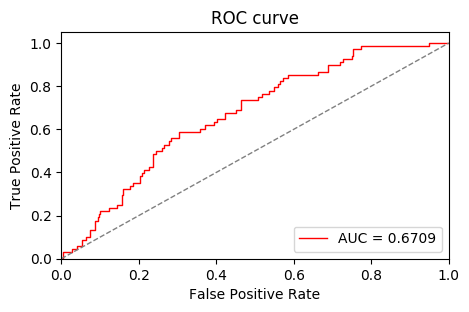

In [38]:
# ROC曲線を描画
lw = 1
plt.figure(figsize=(5,3),dpi=100)
plt.plot(fpr, tpr, color = 'red', lw = lw, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [39]:
# weight : 
# gain :
# cover :
importance = model.get_booster().get_score(fmap='10.fmap/xgb.fmap', importance_type='gain')
importance = sorted(importance.items(), key=operator.itemgetter(1))

# dataframe化
df_importance = pd.DataFrame(importance, columns=['features', 'score'])
df_importance['score'] = df_importance['score'] / df_importance['score'].sum()

In [174]:
df_importance.sort_values('score', ascending=False).head()

,features,score
35,BLGR_2sigma_p_dev_p,0.038
34,BLGR_sigma_m_dev_m,0.038
33,RCI9_slope_m,0.038
32,MA25_slope_p,0.036
31,MA50_slope_p,0.034


<Figure size 432x288 with 0 Axes>

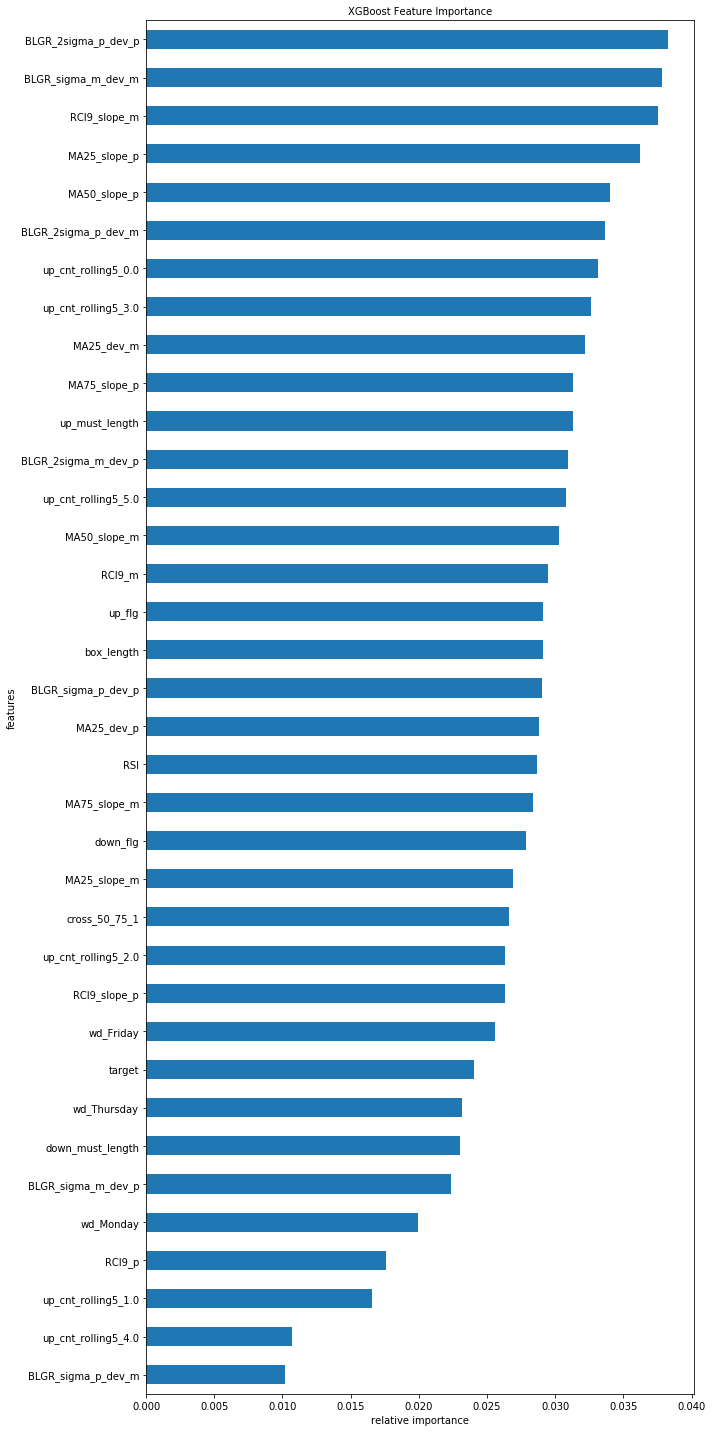

In [170]:
# 重要度を可視化
plt.figure()

df_importance.plot(kind='barh', x='features', y='score', legend=False, figsize=(10,20))
plt.title('XGBoost Feature Importance', fontsize = 10)
plt.xlabel('relative importance')
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.gcf().savefig('feature_importance_xgb.png')

### 各変数の寄与可視化

In [180]:
for i in df_importance.sort_values('score', ascending=False).head().iloc[:, 0]:
    print(i)

BLGR_2sigma_p_dev_p
BLGR_sigma_m_dev_m
RCI9_slope_m
MA25_slope_p
MA50_slope_p


In [50]:
cols =  model.get_booster().feature_names

In [128]:
# 個別のデータに対する各変数の寄与
pred_cntrb_sample = xgb.DMatrix(X_valid)
pred_cntrb = model.get_booster().predict(pred_cntrb_sample, pred_contribs=True)

/usr/local/opt/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


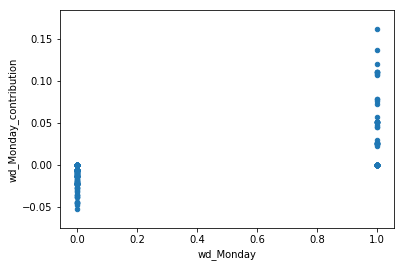

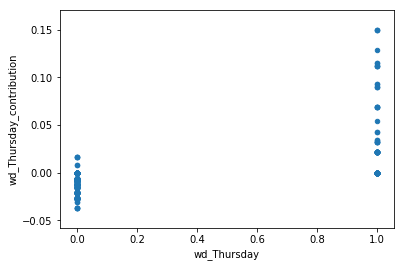

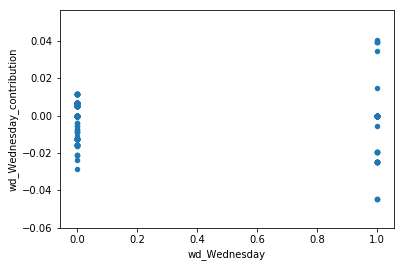

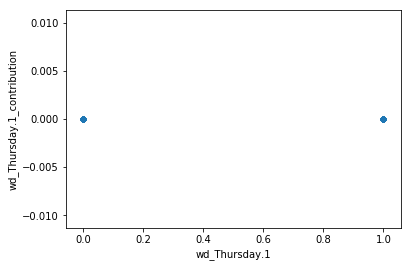

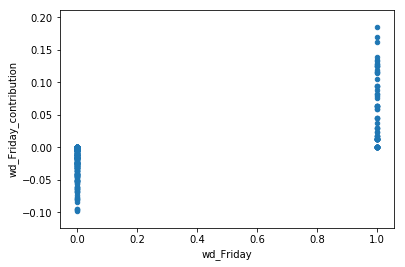

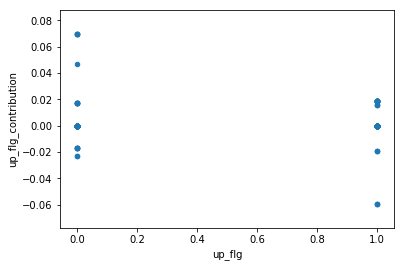

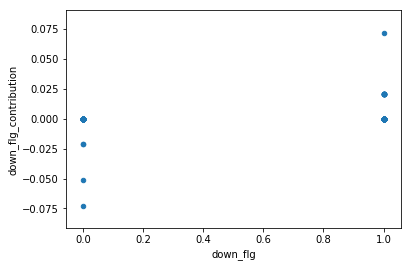

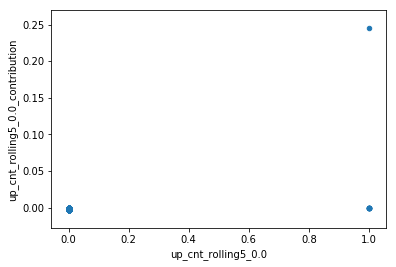

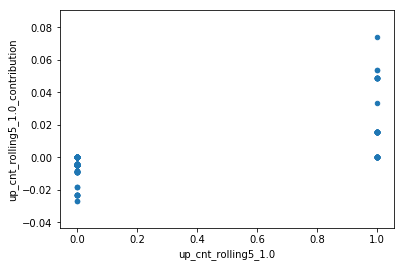

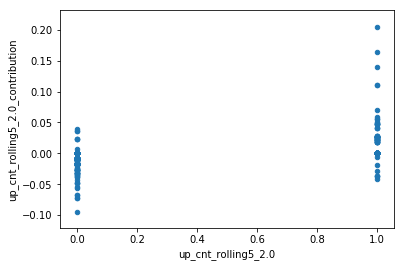

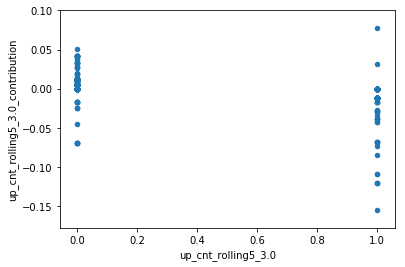

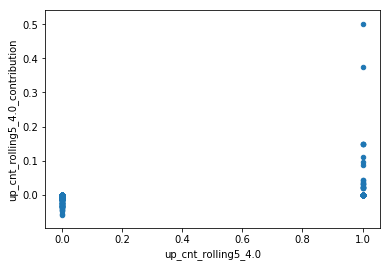

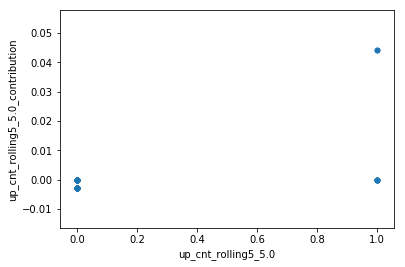

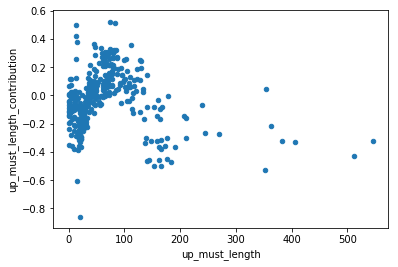

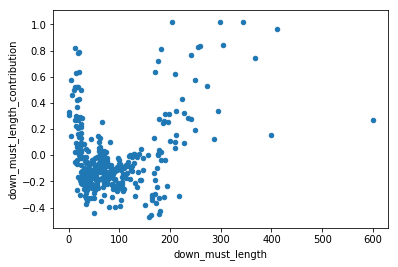

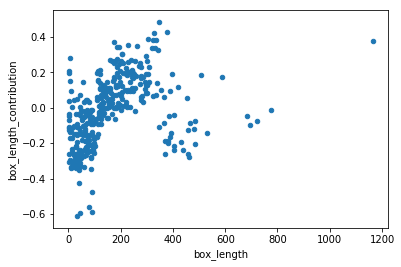

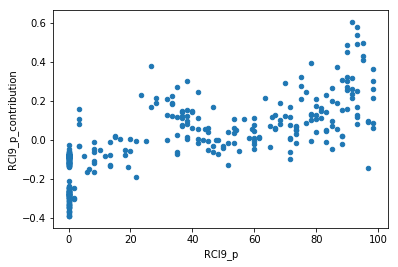

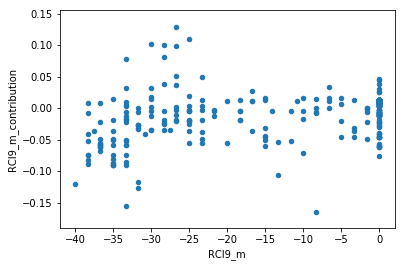

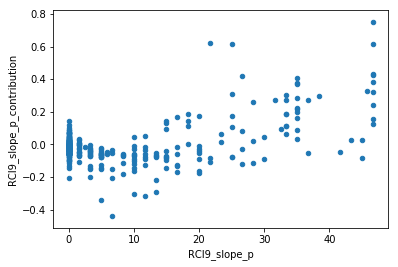

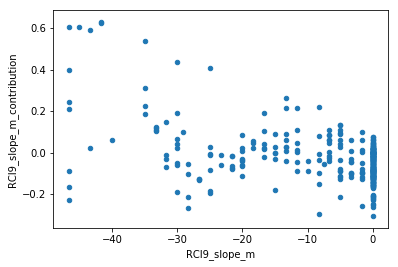

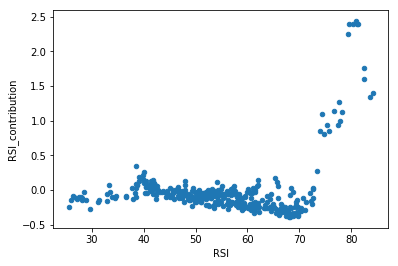

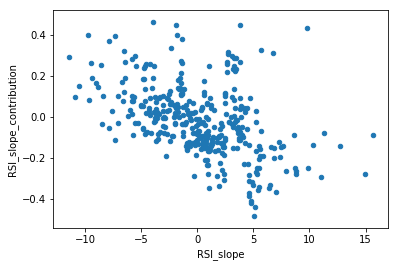

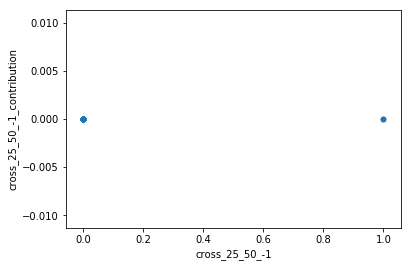

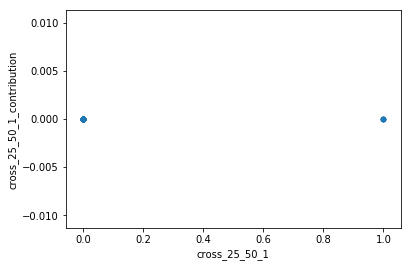

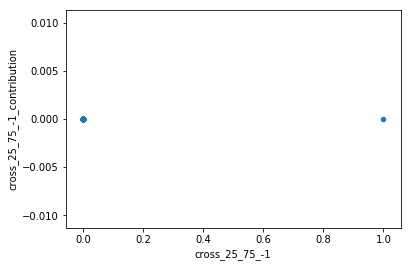

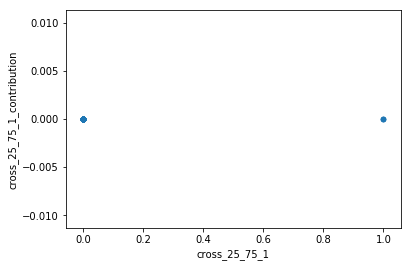

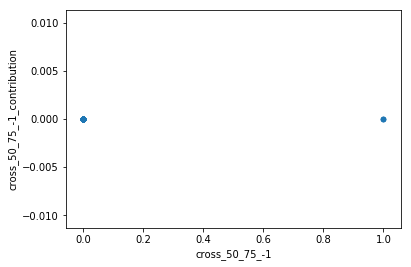

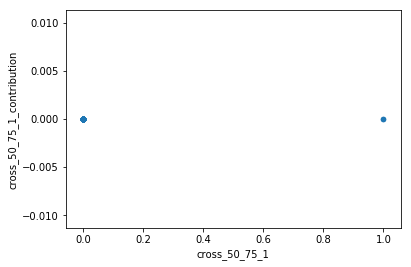

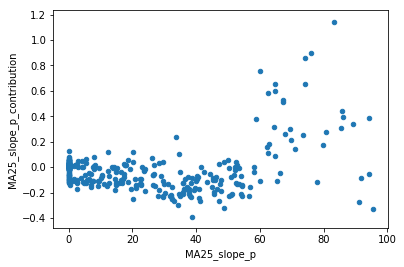

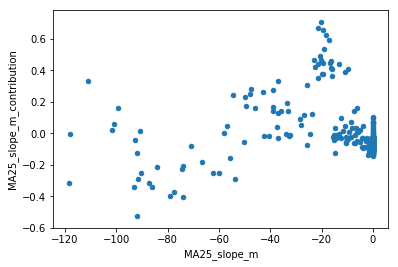

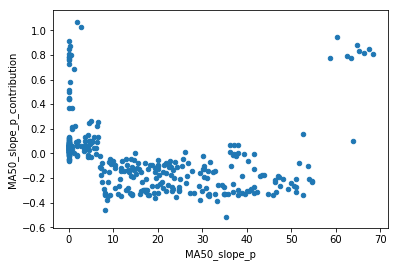

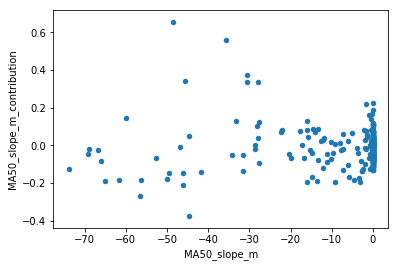

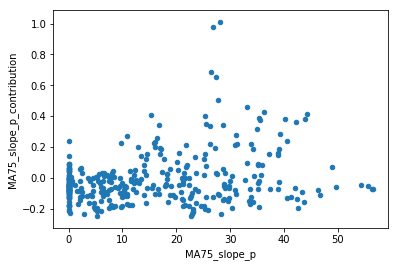

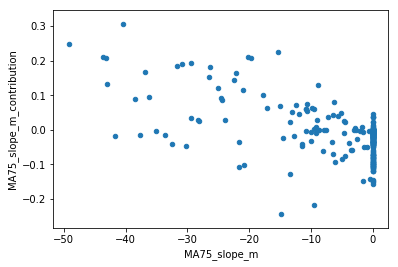

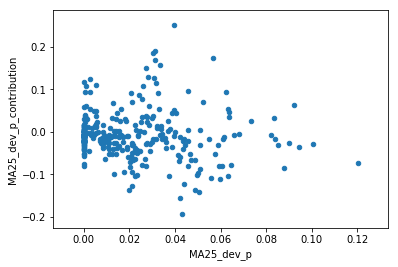

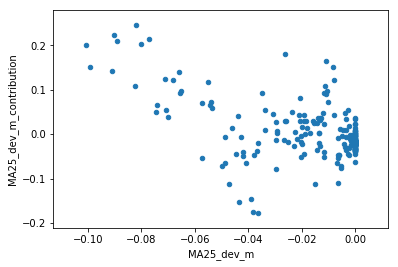

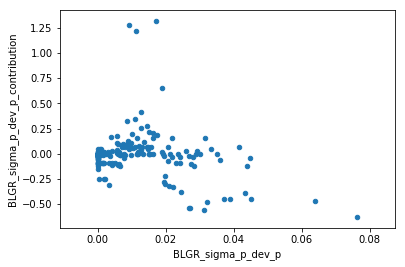

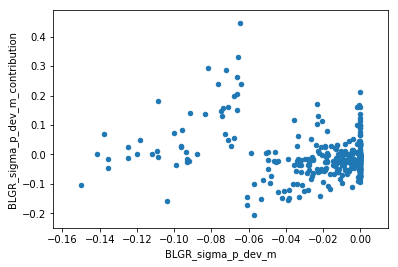

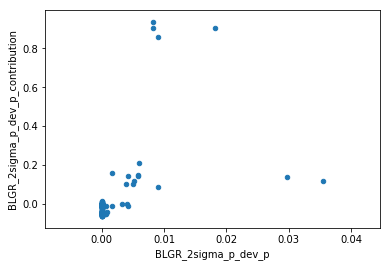

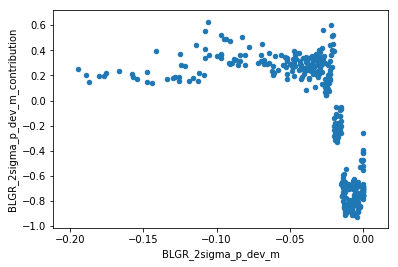

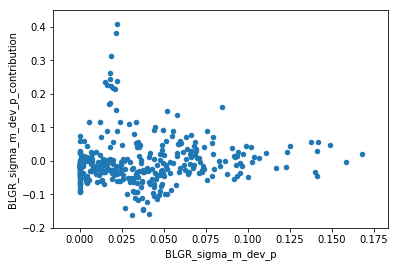

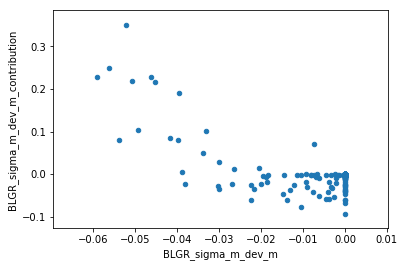

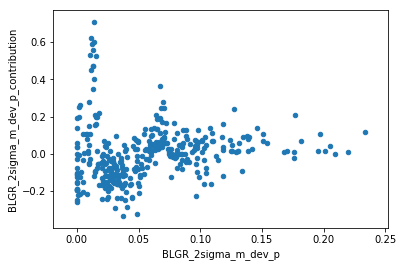

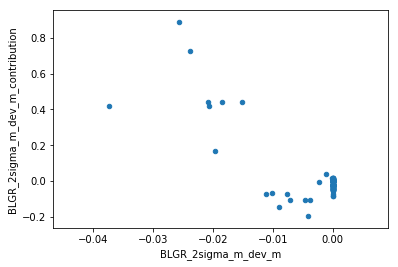

In [166]:
df= pd.DataFrame({ cols[0] : X_valid[cols[0]],
                  str(cols[0]) + '_contribution' : pred_cntrb[:, 0]  })

for i in range(1, len(cols)):
    df[ cols[i]] = X_valid[cols[i]]
    df[ str(cols[i]) + '_contribution' ] = pred_cntrb[:, i]
    
for i in range(0, len(cols)):
    df.plot(kind='scatter', x=cols[i], y= cols[i] + '_contribution' )
    
#df.head()